Import Libraries

In [20]:
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score, f1_score
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import SelectFromModel
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import joblib

Import Dataset

In [21]:
users_df = pd.read_csv('u.csv')
places_df = pd.read_csv('p.csv')

Preprocess the data

In [22]:
users_df['Preferred Activities'] = users_df['Preferred Activities'].apply(eval)
users_df['Bucket list destinations Sri Lanka'] = users_df['Bucket list destinations Sri Lanka'].apply(eval)

Combine all text features for places

In [23]:
places_df['combined_features'] = places_df['name'] + ' ' + places_df['formatted_address'] + ' ' + places_df['latest_reviews'].fillna('')

Create TF-IDF vectorizer

In [24]:
tfidf = TfidfVectorizer(stop_words='english', max_features=1000)
place_tfidf_matrix = tfidf.fit_transform(places_df['combined_features'])

Function to get recommendations

In [25]:
def prepare_data_for_classifier(users_df, places_df, tfidf, sample_size=1000):
    print("Preparing data for classifier...")
    
    all_bucket_list = set()
    for destinations in users_df['Bucket list destinations Sri Lanka']:
        all_bucket_list.update(destinations)
    
    relevant_places = places_df[places_df['name'].isin(all_bucket_list)].reset_index(drop=True)
    
    if len(relevant_places) == 0:
        raise ValueError("No relevant places found. Check if place names in user bucket lists match the names in places_df.")
    
    relevant_place_vectors = tfidf.transform(relevant_places['combined_features'])
    
    X = []
    y = []
    
    sampled_users = users_df.sample(n=min(sample_size, len(users_df)), random_state=42)
    
    for _, user in tqdm(sampled_users.iterrows(), total=len(sampled_users), desc="Processing users"):
        user_preferences = ' '.join(user['Preferred Activities'] + user['Bucket list destinations Sri Lanka'])
        user_vector = tfidf.transform([user_preferences])
        
        similarities = cosine_similarity(user_vector, relevant_place_vectors).flatten()
        
        for place in user['Bucket list destinations Sri Lanka']:
            if place in relevant_places['name'].values:
                place_index = relevant_places.index[relevant_places['name'] == place].tolist()[0]
                X.append(similarities[place_index])
                y.append(1)
        
        negative_places = relevant_places[~relevant_places['name'].isin(user['Bucket list destinations Sri Lanka'])].sample(n=min(5, len(relevant_places)), random_state=42)
        for _, place in negative_places.iterrows():
            place_index = place.name
            X.append(similarities[place_index])
            y.append(0)
    
    if len(X) == 0:
        raise ValueError("No data points generated. Check if user bucket lists contain valid place names.")
    
    return np.array(X).reshape(-1, 1), np.array(y)

Prepare data for model evaluation

In [26]:
print("Preparing data for classifier...")
X, y = prepare_data_for_classifier(users_df, places_df, tfidf)

Preparing data for classifier...
Preparing data for classifier...


Processing users: 100%|██████████| 1000/1000 [00:03<00:00, 304.74it/s]


Split the data

In [27]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

Scale the features

In [28]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

Train the model

In [29]:
print("Training the model...")
clf = RandomForestClassifier(n_estimators=100, max_depth=10, min_samples_split=5, min_samples_leaf=2, random_state=42)
clf.fit(X_train_scaled, y_train)

Training the model...


RandomForestClassifier(max_depth=10, min_samples_leaf=2, min_samples_split=5,
                       random_state=42)

Perform cross-validation

In [30]:
cv_scores = cross_val_score(clf, X_train_scaled, y_train, cv=5)
print(f"Cross-validation scores: {cv_scores}")
print(f"Mean CV score: {cv_scores.mean():.2f} (+/- {cv_scores.std() * 2:.2f})")

Cross-validation scores: [0.90895633 0.91561806 0.92666667 0.9162963  0.92148148]
Mean CV score: 0.92 (+/- 0.01)


Make predictions on the test set

In [31]:
print("Making predictions...")
y_pred = clf.predict(X_test_scaled)
print("Predictions complete.")

Making predictions...
Predictions complete.


Calculate metrics

In [32]:
accuracy = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred, average='weighted')
print(f"Accuracy: {accuracy:.2f}")
print(f"F1 Score: {f1:.2f}")

Accuracy: 0.92
F1 Score: 0.92


Classification report

In [33]:
print("\nClassification Report:")
print(classification_report(y_test, y_pred))


Classification Report:
              precision    recall  f1-score   support

           0       0.94      0.93      0.93      1039
           1       0.88      0.90      0.89       649

    accuracy                           0.92      1688
   macro avg       0.91      0.91      0.91      1688
weighted avg       0.92      0.92      0.92      1688



Learning Curve

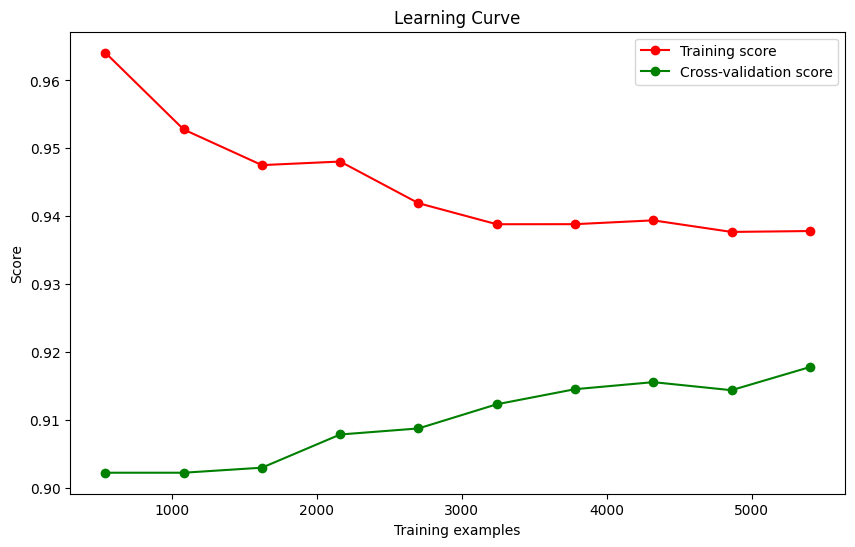

In [34]:
from sklearn.model_selection import learning_curve

train_sizes, train_scores, val_scores = learning_curve(
    clf, X_train_scaled, y_train, train_sizes=np.linspace(0.1, 1.0, 10),
    cv=5, scoring='accuracy', n_jobs=-1)

plt.figure(figsize=(10, 6))
plt.plot(train_sizes, np.mean(train_scores, axis=1), 'o-', color='r', label='Training score')
plt.plot(train_sizes, np.mean(val_scores, axis=1), 'o-', color='g', label='Cross-validation score')
plt.title('Learning Curve')
plt.xlabel('Training examples')
plt.ylabel('Score')
plt.legend(loc='best')
plt.show()

Model summary

In [35]:
print("\nModel Summary")
print(f"Number of users: {len(users_df)}")
print(f"Number of places: {len(places_df)}")
print(f"TF-IDF Vocabulary Size: {len(tfidf.vocabulary_)}")
print(f"Random Forest Classifier")
print(f"  Number of trees: {clf.n_estimators}")
print(f"  Max depth: {clf.max_depth}")
print(f"  Min samples split: {clf.min_samples_split}")
print(f"  Min samples leaf: {clf.min_samples_leaf}")


Model Summary
Number of users: 10000
Number of places: 411
TF-IDF Vocabulary Size: 1000
Random Forest Classifier
  Number of trees: 100
  Max depth: 10
  Min samples split: 5
  Min samples leaf: 2


Example Recommendation Function

In [36]:
def get_recommendations(user_id, top_n=5):
    user = users_df[users_df['User ID'] == user_id].iloc[0]
    user_preferences = ' '.join(user['Preferred Activities'] + user['Bucket list destinations Sri Lanka'])
    user_vector = tfidf.transform([user_preferences])
    
    cosine_similarities = cosine_similarity(user_vector, place_tfidf_matrix).flatten()
    related_places_indices = cosine_similarities.argsort()[::-1]
    
    recommended_places = places_df.iloc[related_places_indices]
    return recommended_places.head(top_n)['name'].tolist()

Example recommendation

In [37]:
example_user_id = users_df['User ID'].iloc[2]
recommendations = get_recommendations(example_user_id)
print(f"\nTop 5 recommendations for User {example_user_id}")
for i, place in enumerate(recommendations, 1):
    print(f"{i}. {place}")


Top 5 recommendations for User 3
1. Mirissa Beach
2. Jungle Beach
3. Negombo Lagoon
4. Cinnamon Bentota Beach
5. Negombo


Save Model

In [38]:
joblib.dump(clf, 'model.h5')
print("Model saved as model.h5")

Model saved as model.h5
